<div align="center">
    <img src="https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/320/apple/325/watermelon_1f349.png">
</div>

<h1 align="center">Fruits Classification using a CNN</h1>

# Setting up

## Installing packages

In [1]:
%%capture
# %%capture for discarding the output, remove it if you need to debug this cell
# Using this syntax as recommended here: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
import sys
!{sys.executable} -m pip install opendatasets
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install sklearn
!{sys.executable} -m pip install tensorflow
!{sys.executable} -m pip install keras

## Importing dependencies

In [2]:
import opendatasets as od
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np
from sklearn.datasets import load_files
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

## Downloading dataset

In [3]:
# Using the opendatasets library: https://github.com/JovianML/opendatasets
# Uses the Kaggle Official API, will ask for your Kaggle API credentials
od.download('https://www.kaggle.com/datasets/moltean/fruits') # 1.28GB, might take a little while to DL

Skipping, found downloaded files in "./fruits" (use force=True to force download)


# Exploring the data

-> Showing a couple of images to get a sense of how the data looks:

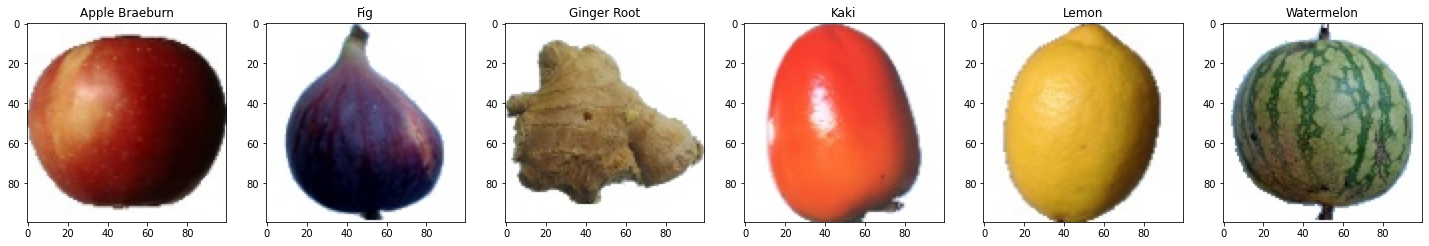

In [4]:
path = './fruits/fruits-360_dataset/fruits-360/'
train_path = f'{path}Training/'
test_path = f'{path}Test/'

fruits = ['Apple Braeburn', 'Fig', 'Ginger Root', 'Kaki', 'Lemon', 'Watermelon']

_, axarr = plt.subplots(1, 6, figsize = (25, 5))
for i, fruit in enumerate(fruits):
    axarr[i].imshow(mpimg.imread(f'{train_path}{fruit}/12_100.jpg'))
    axarr[i].set_title(fruits[i])

-> Counting the number of different categories, and the number of samples, for both training and testing sets:  
(Training and testing sets are already separated in this dataset, there is no need to split it ourselves)

In [5]:
train_categories, train_samples_counts = [], []
test_categories, test_samples_counts = [], []

for i in sorted(os.listdir(train_path)):
    train_categories.append(i)
    train_samples_counts.append(len(os.listdir(f'{train_path}{i}')))

for i in sorted(os.listdir(test_path)):
    test_categories.append(i)
    test_samples_counts.append(len(os.listdir(f'{test_path}{i}')))

print('train_categories == test_categories ?', train_categories == test_categories)
categories = train_categories
print('Number of categories:', len(categories))

train_categories == test_categories ? True
Number of categories: 131


In [6]:
count_train_samples = sum(train_samples_counts)
count_test_samples = sum(test_samples_counts)
count_samples_total = count_train_samples + count_test_samples
print('Number of samples:')
print('Train:', count_train_samples)
print('Test:', count_test_samples)
print('Total:', count_samples_total)
print('Ratio Train/Total:', '{0:.0%}'.format(count_train_samples / count_samples_total))

Number of samples:
Train: 67692
Test: 22688
Total: 90380
Ratio Train/Total: 75%


-> Plotting the number of samples per categories:

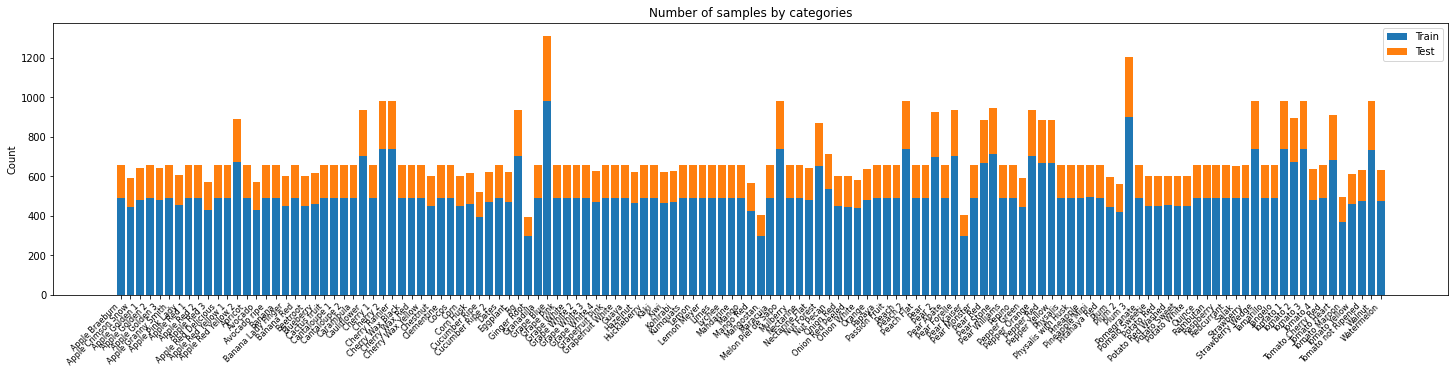

In [7]:
plt.rcParams["figure.figsize"] = [25, 5]

_, ax = plt.subplots()
ax.set_title('Number of samples by categories')
ax.bar(categories, train_samples_counts, label='Train')
ax.bar(categories, test_samples_counts, bottom=train_samples_counts, label='Test')
ax.set_ylabel('Count')
ax.legend()

plt.xticks(categories, fontsize=8, rotation=45, ha="right")
plt.show()

# Loading the dataset

In [8]:
# Utility function for loading the whole dataset using sklearn's load_files function
def load_dataset(path):
    data = load_files(path)
    x = np.array(data['filenames'])
    y = np.array(data['target'])
    return x, y

In [9]:
# Loading the dataset, this may take some time
x_train, y_train = load_dataset(train_path)
x_test, y_test = load_dataset(test_path)
target_labels = np.array(categories)

In [10]:
print(x_train[:2])
print(x_test[:2])

['./fruits/fruits-360_dataset/fruits-360/Training/Cherry 2/r_263_100.jpg'
 './fruits/fruits-360_dataset/fruits-360/Training/Nut Pecan/73_100.jpg']
['./fruits/fruits-360_dataset/fruits-360/Test/Potato Red/r2_109_100.jpg'
 './fruits/fruits-360_dataset/fruits-360/Test/Mango/r_218_100.jpg']


For now, x_train and x_test contain the paths to the images. We will load the actual images after that.

In [11]:
print(y_train)
print(y_test)

[27 73 68 ... 90 84 86]
[107  64  88 ...  58  64  16]


y_train and y_test contain the number of the category to which each image belong.

In [12]:
print(target_labels[:12])

['Apple Braeburn' 'Apple Crimson Snow' 'Apple Golden 1' 'Apple Golden 2'
 'Apple Golden 3' 'Apple Granny Smith' 'Apple Pink Lady' 'Apple Red 1'
 'Apple Red 2' 'Apple Red 3' 'Apple Red Delicious' 'Apple Red Yellow 1']


target_labels is just the labels of the categories as a numpy array.

-> Loading the images:

In [13]:
# Utility function for loading the images using TensorFlow Kera's load_image and img_to_array functions
# load_image loads the image at the designated path into PIL format
# img_to_array converts the PIL Image instance into A 3D Numpy array
def load_images_to_arrays(paths):
    images_arrays = []
    for path in paths:
        images_arrays.append(img_to_array(load_img(path)))
    return np.array(images_arrays)

Actually loading the images, this may take some time:

In [14]:
x_train = load_images_to_arrays(x_train)

In [15]:
x_test = load_images_to_arrays(x_test)

In [16]:
print(x_train.shape)
print(x_test.shape)

(67692, 100, 100, 3)
(22688, 100, 100, 3)


(Number of samples, Image height, Image width, RGB)

In [17]:
print(x_train[0][50][50])

[181.  57.  65.]


This is the RGB value of the center pixel of the first training image.

# Data Preprocessing

-> Image Normalization (scaling pixels' RGB values from 0-255 to 0-1):  
This reduces training time by simplifying the computations.

In [18]:
x_train = x_train.astype('float32') / 255

In [19]:
x_test = x_test.astype('float32') / 255

In [20]:
print(x_train[0][50][50])

[0.70980394 0.22352941 0.25490198]


This is the RGB value of the center pixel of the first training image on a scale going from 0 to 1 instead of 0 to 255.

-> Turning responses into vectors of categories:  
ex: 'Strawberry' => [0, 0, 0, 1, 0] out of ['Banana', 'Peach', 'Kiwi', 'Strawberry', 'Cherry']

In [21]:
if len(np.unique(target_labels)) == len(np.unique(y_train)) == len(np.unique(y_test)):
    number_of_classes = len(np.unique(target_labels))

In [22]:
print('Y train dimension::', y_train.shape)
print('Y test dimension:', y_test.shape)

Y train dimension:: (67692,)
Y test dimension: (22688,)


In [23]:
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

In [24]:
print('Y train dimension:', y_train.shape)
print('Y test dimension:', y_test.shape)

Y train dimension: (67692, 131)
Y test dimension: (22688, 131)


# Building the CNN model

In [25]:
# Basic model with a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential()

2022-08-11 22:26:23.263801: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


-> Feature extraction part:

In [26]:
# 2D convolutional layer: extracts low-level features after applying filters to original input to reduce their number
model.add(Conv2D(filters = 16,
                 kernel_size = 2,
                 input_shape = (100, 100, 3),
                 padding='same'))

# Activation function: decides which neurons should fire. We use ReLU because it works great with CNNs and it's fast.
model.add(Activation('relu'))

# Reduces dimensionality
model.add(MaxPooling2D(pool_size = 2))

# Extracts medium-level features
model.add(Conv2D(filters = 32,
                 kernel_size = 2,
                 activation = 'relu',
                 padding = 'same'))

# Reduces dimensionality
model.add(MaxPooling2D(pool_size = 2))

# Extracts high-level features
model.add(Conv2D(filters = 64,
                 kernel_size = 2,
                 activation = 'relu',
                 padding = 'same'))

# Reduces dimensionality
model.add(MaxPooling2D(pool_size = 2))

# Extracts top-level features
model.add(Conv2D(filters = 128,
                 kernel_size = 2,
                 activation = 'relu',
                 padding = 'same'))

# Reduces dimensionality
model.add(MaxPooling2D(pool_size = 2))

-> Classification part:

In [27]:
# Drop some neurons from previous layers to reduce overfitting
model.add(Dropout(0.3))

# Converts the pooled 2D array of features into a 1D array
model.add(Flatten())

# Reduces the number of features
model.add(Dense(150))

# ReLU activation function: decides which neurons should fire as before
model.add(Activation('relu'))

# Reduces overfitting
model.add(Dropout(0.4))

# Softmax activation function: normalize the output to probabilities for each predicted output classes
model.add(Dense(131, activation = 'softmax'))

-> Model summary:

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      208       
                                                                 
 activation (Activation)     (None, 100, 100, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        8

-> Compiling the model:

In [28]:
model.compile(loss = 'categorical_crossentropy', # more than two output classes
              optimizer = 'rmsprop', # Root Mean Squared Propagation optimization algorithm
              metrics = ['accuracy']) # percentage of correct predictions over all predictions

# Training the model

In [29]:
history = model.fit(x_train,
                    y_train,
                    batch_size = 32,
                    epochs = 10,
                    validation_data = (x_test, y_test),
                    verbose = 2,
                    shuffle = True)

Epoch 1/10
2116/2116 - 390s - loss: 1.0635 - accuracy: 0.7084 - val_loss: 0.3058 - val_accuracy: 0.9227 - 390s/epoch - 184ms/step
Epoch 2/10
2116/2116 - 361s - loss: 0.1499 - accuracy: 0.9516 - val_loss: 0.2969 - val_accuracy: 0.9271 - 361s/epoch - 171ms/step
Epoch 3/10
2116/2116 - 326s - loss: 0.0943 - accuracy: 0.9700 - val_loss: 0.3065 - val_accuracy: 0.9444 - 326s/epoch - 154ms/step
Epoch 4/10
2116/2116 - 336s - loss: 0.0722 - accuracy: 0.9775 - val_loss: 0.2104 - val_accuracy: 0.9697 - 336s/epoch - 159ms/step
Epoch 5/10
2116/2116 - 332s - loss: 0.0679 - accuracy: 0.9806 - val_loss: 0.1496 - val_accuracy: 0.9764 - 332s/epoch - 157ms/step
Epoch 6/10
2116/2116 - 323s - loss: 0.0689 - accuracy: 0.9814 - val_loss: 0.1773 - val_accuracy: 0.9717 - 323s/epoch - 153ms/step
Epoch 7/10
2116/2116 - 305s - loss: 0.0713 - accuracy: 0.9817 - val_loss: 0.2068 - val_accuracy: 0.9740 - 305s/epoch - 144ms/step
Epoch 8/10
2116/2116 - 308s - loss: 0.0712 - accuracy: 0.9827 - val_loss: 0.1777 - val_acc

# Model evaluation

In [30]:
scores = model.evaluate(x_test, y_test)
print('Final test accuracy:', scores[1])

709/709 [==============================] - 21s 30ms/step - loss: 0.2189 - accuracy: 0.9749
Final test accuracy: 0.9749206900596619


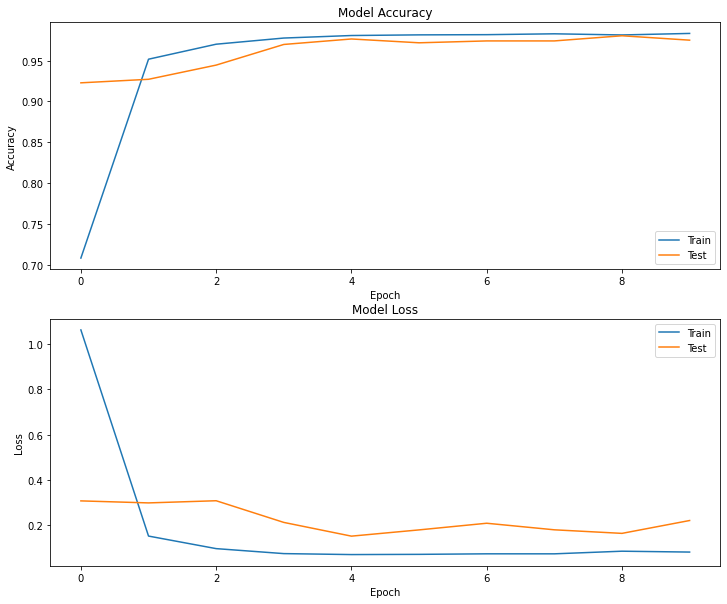

In [31]:
plt.figure(1, figsize = (12, 10))  

# Accuracy history
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'lower right')

# Loss history
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper right')

plt.show()

# Conclusion

We are now able to classify fruits in this dataset with an accuracy of 97% using a Convolutional Neural Network.

# Predictions

In [32]:
predictions = model.predict(x_test)

709/709 [==============================] - 20s 28ms/step


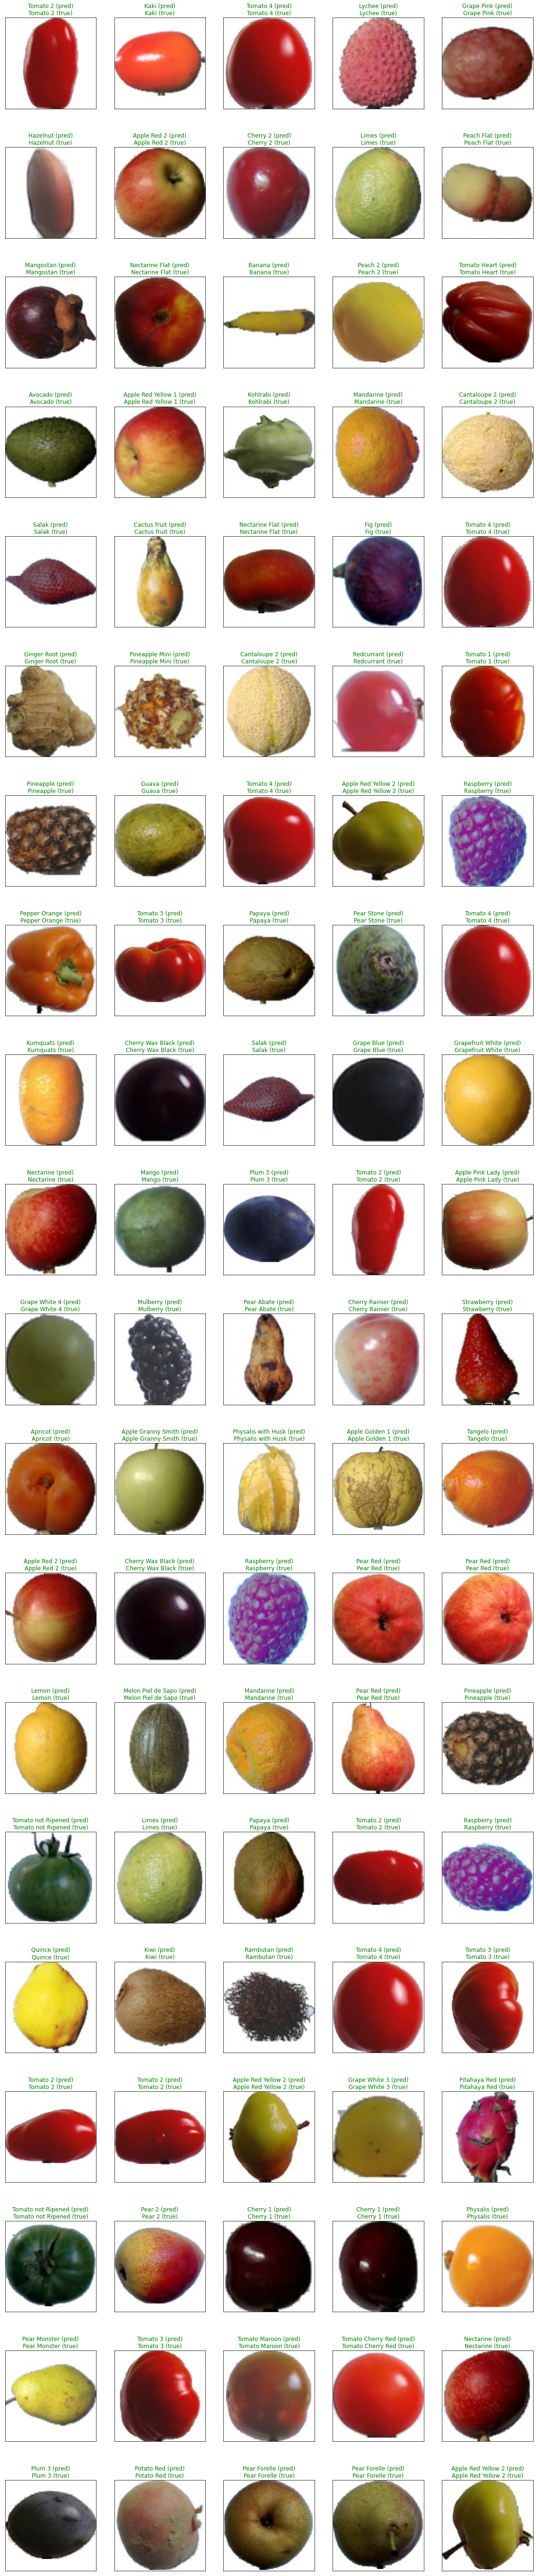

In [33]:
fig = plt.figure(figsize = (20, 100))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size = 100, replace = False)):
    pred_idx = np.argmax(predictions[idx])
    true_idx = np.argmax(y_test[idx])
    
    ax = fig.add_subplot(20, 5, i+1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title(f'{target_labels[pred_idx]} (pred)\n{target_labels[true_idx]} (true)',
                 color = ('green' if pred_idx == true_idx else 'red'))